# Binary Classification (BERT with PyTorch)
By Yiting Mao

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install kaggle
!pip install 'fsspec>=0.3.3'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 8.5 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
     |████████████████████████████████| 596 kB 63.5 MB/s 
     |████████████████████████████████| 6.6 MB 48.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 7.8 MB/s 


In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import matthews_corrcoef, f1_score, precision_score, classification_report, confusion_matrix
import torch.nn.functional as F
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import tensorflow as tf
import dask.bag as db
import pandas as pd
import numpy as np
import jieba as jb
import random
import time
import datetime
import torch
import re
import os
import nltk
nltk.download('stopwords')
import scipy.cluster.hierarchy as hcluster
import scipy
from sklearn import datasets
import json
import itertools

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Setup
## 1.1 Training using the Colab GPU

In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


# 2. Load arXiv Dataset
## 2.1. Download & Extract

In [ ]:
token = {"username":"karinmao","key":"0145306b9df944a40f90e51f15167f9c"}
with open('/content/kaggle.json','w') as file:
  json.dump(token,file)

!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content
!kaggle datasets download -d Cornell-University/arxiv
!unzip -uq "/content/datasets/Cornell-University/arxiv/arxiv.zip" -d "/content/datasets/Cornell-University/arxiv"

# load data
docs = db.read_text('/content/datasets/Cornell-University/arxiv/arxiv-metadata-oai-snapshot.json').map(json.loads)

- path is now set to: /content
 99% 1.04G/1.05G [00:18<00:00, 57.5MB/s]
100% 1.05G/1.05G [00:18<00:00, 60.2MB/s]


In [ ]:
# define target year
year = 2021

# Submissions by datetime
get_year = lambda x: x['versions'][-1]['created'].split(' ')[3]

# get only necessary fields
trim = lambda x: {'id': x['id'],
                  'title': x['title'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],
                  'time':x['versions'][-1]['created'].split(' ')[3]}

# filter for papers published on or after ????-01-01
docs_df = (docs.filter(lambda x: int(get_year(x)) > (year-1))
               .filter(lambda x: int(get_year(x)) < (year+1))
               .map(trim)
               .compute())

# convert to pandas dataframe
docs_df = pd.DataFrame(docs_df)

# add main category: list
docs_df['main_category'] = docs_df.category.apply(lambda x:[a.split('.')[0] for a in x][0].split())

# add main category 2: not list
docs_df['main_category2'] = docs_df.main_category.apply(lambda x: x[0])

In [ ]:
docs_df2 = docs_df[['title','abstract','main_category','main_category2','category','time']]

# Report the number of papers
print('Number of total papers in year {:}: {:,}\n'.format(year, docs_df.shape[0]))

# Display 10 random rows from the data.
docs_df2.sample(10)

Number of total papers in year 2021: 203,296



,title,abstract,main_category,main_category2,category,time
13453,Analytic torsion for arithmetic locally symmet...,In this paper we define a regularized versio...,[math],math,[math.RT],2021
170403,StARformer: Transformer with State-Action-Rewa...,Reinforcement Learning (RL) can be considere...,[cs],cs,"[cs.LG, cs.AI]",2021
201927,On methods for radiometric surveying in radiot...,Radiometric surveys in radiotherapy bunkers ...,[physics],physics,"[physics.med-ph, physics.ins-det]",2021
9969,A Potential Mechanism for Inflation from Swamp...,Inflation is the currently accepted paradigm...,[hep-th],hep-th,"[hep-th, astro-ph.CO, hep-ph]",2021
7979,Is it Raining Outside? Detection of Rainfall u...,In integrated surveillance systems based on ...,[cs],cs,[cs.CV],2021
78298,Gorenstein weak global dimension is symmetric,We study the Gorenstein weak global dimensio...,[math],math,"[math.RA, math.AC]",2021
6559,"Mapping analytic surgery to homology, higher r...",Let $\Gamma$ be a f.g. discrete group and le...,[math],math,"[math.KT, math.DG]",2021
81886,Quantifying the efficacy of childcare services...,Women are set back in the labor market after...,[physics],physics,"[physics.soc-ph, cs.CY]",2021
172750,Phenomenological Effects of CPT and Lorentz In...,It is well known that a fundamental theorem ...,[hep-ph],hep-ph,[hep-ph],2021
109573,Constructions of Binary Optimal Locally Repair...,"Locally repairable codes (LRCs), which can r...",[cs],cs,"[cs.IT, math.IT]",2021


Text(0.5, 1.0, 'year = 2021')

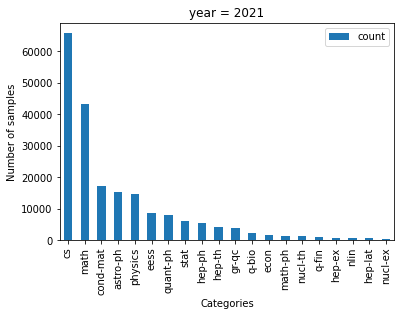

In [ ]:
d = {'cat':docs_df2['main_category2'].value_counts().index, 'count': docs_df2['main_category2'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
num_labels = len(df_cat)

# plot samples - categories
df_cat.plot('cat','count',kind='bar')
plt.xlabel('Categories')
plt.ylabel('Number of samples')
plt.title('year = %s'%(year))

In [ ]:
top5 = df_cat['cat'][:5].tolist()
comb_list = list(itertools.combinations(top5, 2))

dict = {'astro-ph': 9, 'cond-mat': 3, 'cs': 6, 'econ': 16, 'eess': 18, 'funct-an': 20, 'gr-qc': 11, 'hep-ex': 19, 'hep-lat': 15,
 'hep-ph': 1,'hep-th': 4, 'math': 0, 'math-ph': 7, 'nlin': 10, 'nucl-ex': 12, 'nucl-th': 17, 'physics': 2, 'q-alg': 21,
 'q-bio': 13, 'q-fin': 14, 'quant-ph': 5, 'stat': 8, 'alg-geom':22, 'chao-dyn': 23, 'dg-ga': 24, 'adap-org': 25, 'solv-int': 26}

'cs'

In [ ]:
comb_list

[('cs', 'math'),
 ('cs', 'cond-mat'),
 ('cs', 'astro-ph'),
 ('cs', 'physics'),
 ('math', 'cond-mat'),
 ('math', 'astro-ph'),
 ('math', 'physics'),
 ('cond-mat', 'astro-ph'),
 ('cond-mat', 'physics'),
 ('astro-ph', 'physics')]

In [ ]:
# function for removing punctuations in abstracts
def remove_punctuation(line):
    line = str(line)
    if line.strip() == '':
        return ''
    rule = re.compile("[^0-9a-zA-Z\s-]")
    line = rule.sub('', line).strip()
    return line

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def filter_data(docs_df2, cat1, cat2, i):

      dict = {'astro-ph': 9, 'cond-mat': 3, 'cs': 6, 'math': 0, 'physics': 2}

      # filter for papers in 'cat1' or 'cat2' area
      docs_df3 = docs_df2[(docs_df2.main_category.apply(lambda x: cat1 in x )==True)|(docs_df2.main_category.apply(lambda x: cat2 in x )==True)]

      # Report the number of papers in 'cat1' or 'cat2' area
      print('Number of papers in {:} or {:} area: {:,}\n'.format(cat1, cat2, docs_df3.shape[0]))

      # define stopwords
      #stopwords = nltk.corpus.stopwords.words("english")

      # remove punctuation
      docs_df3['clean_abstract'] = docs_df3['abstract'].apply(remove_punctuation)
      docs_df3['clean_title'] = docs_df3['title'].apply(remove_punctuation)

      # remove stopwords
      # docs_df3['cut'] = docs_df3['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))

      docs_df4 = docs_df3[['clean_abstract','main_category2','category']]

      # cat tansfer to id
      docs_df4['cat_id'] = docs_df4['main_category2'].map(dict)

      return docs_df4

# 3. Tokenization + dataset split

In [ ]:
def bert_tokenizer_dataset_split(docs_df4_pair):

  abstracts = docs_df4_pair.clean_abstract.values
  labels = docs_df4_pair.cat_id.values

  # Load the BERT tokenizer
  print('Loading BERT tokenizer...')
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

  max_len = 0
  sum_len = 0

  # For every sample in abstracts...
  for sample in abstracts:

      # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
      input_ids = tokenizer.encode(sample, add_special_tokens=True)

      # Update sum of total sentence length
      sum_len += len(input_ids)

      # Update the maximum sentence length.
      max_len = max(max_len, len(input_ids))

  print('Max abstract length: ', max_len)
  print('Average abstract length: ', sum_len/len(abstracts))

  # Tokenize all of the abstracts and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sample in abstracts:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sample,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 128,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # # Print sentence 0, now as a list of IDs.
  # print('Original: ', abstracts[0])
  # print('Token IDs:', input_ids[0])

  # Combine the training inputs into a TensorDataset.
  dataset = TensorDataset(input_ids, attention_masks, labels)

  # Create a 80-10-10 train-validation-test split.
  # Calculate the number of samples to include in each set.
  train_size = int(0.8 * len(dataset))
  val_size = int(0.1 * len(dataset))
  test_size = len(dataset) - (train_size + val_size)

  # Divide the dataset by randomly selecting samples.
  trainval_dataset, test_dataset = random_split(dataset, [(train_size+val_size), test_size])
  train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

  print('{:>5,} training samples'.format(train_size))
  print('{:>5,} validation samples'.format(val_size))
  print('{:>5,} testing samples'.format(test_size))
  print(len(dataset),'total samples')

  # The DataLoader needs to know our batch size for training, so we specify it 
  # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
  # size of 16 or 32.
  batch_size = 16

  # Create the DataLoaders for our training and validation sets.
  # We'll take training samples in random order. 
  train_dataloader = DataLoader(
              train_dataset,  # The training samples.
              sampler = RandomSampler(train_dataset), # Select batches randomly
              batch_size = batch_size # Trains with this batch size.
          )

  # For validation the order doesn't matter, so we'll just read them sequentially.
  validation_dataloader = DataLoader(
              val_dataset, # The validation samples.
              sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
              batch_size = batch_size # Evaluate with this batch size.
          )

  # For validation the order doesn't matter, so we'll just read them sequentially.
  test_dataloader = DataLoader(
              test_dataset, # The validation samples.
              sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
              batch_size = batch_size # Evaluate with this batch size.
          )
  
  return train_dataloader, validation_dataloader, test_dataloader, train_size, val_size, test_size

# 4. Load Fine-Tuned Model

# 5. Test the Classification model

In [ ]:
def prediction_bert(docs_df2, comb_list):

    ## Load the model
    # Load a trained model and vocabulary that you have fine-tuned
    output_dir = '/content/drive/MyDrive/Colab Notebooks/M4R/BERT tutorial/model_save'
    model = BertForSequenceClassification.from_pretrained(output_dir)
    tokenizer = BertTokenizer.from_pretrained(output_dir)

    # Copy the model to the GPU.
    model.to(device)

    # Put model in evaluation mode
    model.eval()


    for i in range(len(comb_list)):

      print(comb_list[i])
      cat1 = comb_list[i][0]
      cat2 = comb_list[i][1]

      ## data filtering
      docs_df4 = filter_data(docs_df2, cat1, cat2, i)

      ## bert tokenizer & dataset split
      train_dataloader, validation_dataloader, test_dataloader, train_size, val_size, test_size = bert_tokenizer_dataset_split(docs_df4)

      ## predicting
      # Tracking variables 
      predictions, true_labels = [], []
      predictions_10, true_labels_10 = [], []
      test_accuracy_10 = [true_labels]
      sum_acc = 0

      # Prediction on test set
      print('Predicting labels for {:,} test sentences...'.format(test_size))

      # Predict
      for batch in test_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            result = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask,
                          return_dict=True)

        logits = result.logits
        pred_label = logits.argmax(dim=1)

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        pred_label = pred_label.to('cpu').numpy()
        # print('true',label_ids)
        # print('pre',pred_label)
        
        # Store predictions and true labels
        predictions.extend(pred_label.tolist())
        true_labels.extend(label_ids.tolist())
        # print('true',true_labels)
        # print('pre',predictions)
        sum_acc += flat_accuracy(logits, label_ids)

      test_accuracy = sum_acc/len(test_dataloader)
      predictions_10.append(predictions)
      true_labels_10.append(true_labels)
      test_accuracy_10.append(test_accuracy)
      print('truelabel',true_labels)
      print('prediction',predictions)
      print("  Accuracy: {0:.2f}".format(test_accuracy))
      print('DONE.')

    return test_accuracy_10, true_labels_10, predictions_10

test_accuracy_10, true_labels_10, predictions_10 = prediction_bert(docs_df2, comb_list)

('cs', 'math')
Number of papers in cs or math area: 108,947



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Loading BERT tokenizer...


Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max abstract length:  566
Average abstract length:  185.76351804088227


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


87,157 training samples
10,894 validation samples
10,896 testing samples
108947 total samples
Predicting labels for 10,896 test sentences...
truelabel [6, 6, 0, 6, 0, 6, 6, 0, 6, 6, 6, 0, 0, 6, 0, 6, 0, 6, 0, 0, 6, 6, 6, 6, 0, 0, 6, 0, 6, 0, 0, 6, 0, 0, 6, 6, 0, 0, 6, 6, 6, 0, 0, 0, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 0, 0, 6, 6, 0, 0, 6, 0, 0, 6, 6, 0, 6, 0, 6, 6, 6, 0, 6, 0, 6, 6, 6, 0, 0, 0, 6, 6, 6, 6, 6, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 0, 0, 6, 0, 6, 0, 6, 0, 6, 6, 6, 6, 6, 0, 6, 0, 6, 0, 0, 0, 0, 0, 6, 0, 6, 6, 6, 0, 0, 0, 6, 6, 0, 6, 6, 6, 0, 6, 0, 6, 0, 0, 0, 6, 0, 0, 6, 6, 6, 6, 0, 6, 0, 0, 0, 6, 0, 0, 6, 6, 0, 0, 0, 6, 6, 6, 6, 0, 6, 0, 6, 0, 6, 6, 6, 6, 0, 0, 6, 6, 6, 0, 6, 6, 6, 0, 6, 6, 6, 0, 6, 6, 0, 6, 6, 6, 6, 6, 0, 0, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 0, 6, 0, 6, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 0, 6, 6, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 6, 6, 0, 0, 0, 6, 0, 0, 6, 6, 0, 0, 0, 6, 6, 6, 6, 0, 6, 0, 6, 6, 0,

Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max abstract length:  566
Average abstract length:  209.67302534249046
66,512 training samples
8,314 validation samples
8,315 testing samples
83141 total samples
Predicting labels for 8,315 test sentences...
truelabel [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 3, 6, 6, 3, 6, 6, 6, 6, 6, 6, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 3, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 3, 6, 6, 6, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 6, 6, 6, 3, 3, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 3, 6, 6, 3, 6, 3, 6, 6, 3, 6, 6, 6, 6, 3, 6, 6, 3, 6, 6, 6, 6, 3, 6, 6, 6, 6, 3, 6, 3, 6, 6, 6, 3, 3, 6, 3, 6, 6, 3, 6, 6, 6, 6, 3, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 3, 6, 3, 6, 6, 3, 6, 6, 3, 6, 6, 6, 6, 6, 6, 3, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 3

Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max abstract length:  566
Average abstract length:  220.62026471930625
64,853 training samples
8,106 validation samples
8,108 testing samples
81067 total samples
Predicting labels for 8,108 test sentences...
truelabel [6, 6, 6, 6, 6, 9, 9, 6, 6, 9, 6, 6, 9, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 9, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 9, 6, 9, 6, 6, 6, 6, 9, 6, 9, 6, 9, 6, 9, 6, 6, 9, 6, 6, 9, 9, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 9, 6, 6, 9, 6, 9, 9, 6, 6, 6, 9, 9, 6, 9, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 9, 6, 6, 9, 6, 6, 6, 9, 6, 6, 9, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 9, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 9, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 9, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6

Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max abstract length:  566
Average abstract length:  209.67085083641967
64,369 training samples
8,046 validation samples
8,047 testing samples
80462 total samples
Predicting labels for 8,047 test sentences...
truelabel [2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 2, 6, 6, 6, 6, 6, 2, 6, 2, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 2, 6, 6, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 2, 6, 6, 6, 6, 2, 6, 2, 2, 6, 6, 6, 2, 2, 6, 2, 2, 2, 6, 6, 6, 6, 2, 6, 2, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 2, 2, 6, 6, 2, 6, 2, 6, 6, 6, 6, 6, 6, 2, 2, 6, 6, 6, 6, 2, 2, 6, 6, 2, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 2, 2, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 2, 6

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max abstract length:  495
Average abstract length:  166.36986686048434
48,430 training samples
6,053 validation samples
6,055 testing samples
60538 total samples
Predicting labels for 6,055 test sentences...
truelabel [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 3, 0, 3, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 3, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 3, 3, 0, 3, 0, 0, 3, 3, 0, 3, 0, 3, 0, 3, 0, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 3, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 3, 0, 0, 3, 0, 3

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max abstract length:  502
Average abstract length:  180.01329022988506
46,771 training samples
5,846 validation samples
5,847 testing samples
58464 total samples
Predicting labels for 5,847 test sentences...
truelabel [0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 9, 0, 9, 0, 0, 9, 0, 0, 9, 0, 9, 9, 9, 9, 0, 0, 0, 0, 9, 0, 0, 0, 0, 9, 9, 9, 9, 0, 0, 9, 9, 0, 0, 0, 0, 9, 0, 9, 9, 0, 0, 9, 9, 9, 0, 0, 9, 9, 9, 0, 0, 0, 0, 9, 0, 0, 0, 9, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 9, 0, 9, 0, 9, 0, 9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 9, 9, 0, 0, 9, 0, 0, 9, 0, 0, 0, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 9, 0, 9, 0, 9, 0, 9, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 0, 9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 9, 0, 0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 9, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max abstract length:  512
Average abstract length:  164.36181060854838
46,287 training samples
5,785 validation samples
5,787 testing samples
57859 total samples
Predicting labels for 5,787 test sentences...
truelabel [2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max abstract length:  502
Average abstract length:  236.3385387960071
26,126 training samples
3,265 validation samples
3,267 testing samples
32658 total samples
Predicting labels for 3,267 test sentences...
truelabel [9, 3, 3, 3, 3, 9, 3, 3, 9, 3, 3, 3, 9, 9, 3, 9, 9, 3, 9, 9, 9, 9, 3, 9, 9, 3, 3, 3, 9, 9, 3, 3, 9, 9, 3, 3, 3, 9, 3, 3, 3, 3, 3, 9, 9, 9, 9, 9, 3, 3, 9, 3, 3, 9, 9, 3, 9, 3, 3, 3, 3, 9, 3, 9, 9, 3, 9, 9, 9, 3, 9, 3, 3, 9, 9, 9, 3, 9, 9, 3, 9, 9, 3, 3, 3, 3, 9, 3, 3, 9, 9, 9, 9, 3, 9, 9, 9, 9, 3, 9, 3, 3, 9, 3, 9, 3, 9, 3, 9, 3, 3, 9, 3, 3, 9, 9, 9, 3, 3, 9, 3, 3, 3, 3, 9, 9, 9, 3, 9, 9, 3, 9, 9, 9, 3, 3, 9, 3, 3, 9, 3, 9, 9, 9, 3, 3, 3, 9, 3, 9, 3, 9, 9, 3, 3, 9, 9, 3, 3, 9, 9, 9, 3, 9, 3, 3, 3, 9, 3, 9, 9, 3, 3, 3, 3, 9, 3, 9, 3, 9, 9, 3, 3, 3, 9, 3, 3, 9, 3, 3, 3, 3, 3, 9, 9, 9, 3, 9, 9, 9, 9, 3, 9, 3, 3, 9, 9, 9, 3, 3, 9, 9, 9, 3, 3, 9, 3, 3, 9, 3, 9, 9, 3, 3, 9, 9, 9, 3, 3, 9, 3, 9, 3, 9, 3, 9, 9, 3, 3, 9, 3, 3, 3, 9, 3, 3, 3, 9, 9, 3, 9, 9, 9, 9, 3, 3, 3, 3, 3, 9, 9,

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max abstract length:  512
Average abstract length:  209.14912800673883
25,642 training samples
3,205 validation samples
3,206 testing samples
32053 total samples
Predicting labels for 3,206 test sentences...
truelabel [3, 2, 3, 3, 3, 2, 3, 2, 2, 2, 3, 2, 2, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 3, 2, 3, 2, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 2, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 3, 3, 2

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max abstract length:  512
Average abstract length:  238.71560092064445
23,983 training samples
2,997 validation samples
2,999 testing samples
29979 total samples
Predicting labels for 2,999 test sentences...
truelabel [9, 2, 2, 2, 9, 2, 2, 2, 2, 2, 2, 2, 9, 9, 9, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 9, 2, 2, 9, 2, 9, 9, 9, 2, 9, 2, 9, 2, 2, 2, 2, 9, 9, 2, 2, 9, 9, 9, 9, 9, 9, 9, 9, 2, 9, 2, 2, 9, 9, 9, 2, 9, 9, 9, 2, 2, 9, 2, 2, 2, 2, 9, 9, 9, 9, 2, 9, 9, 9, 9, 2, 9, 9, 2, 2, 2, 9, 2, 9, 2, 9, 2, 2, 9, 2, 9, 2, 9, 9, 2, 9, 9, 2, 2, 2, 9, 9, 2, 2, 2, 2, 2, 2, 9, 9, 2, 9, 2, 2, 2, 2, 9, 9, 9, 9, 2, 2, 9, 9, 9, 2, 2, 9, 9, 2, 2, 9, 9, 2, 2, 2, 9, 2, 2, 2, 9, 9, 2, 2, 9, 9, 2, 9, 2, 2, 9, 2, 2, 9, 9, 9, 2, 2, 2, 9, 2, 2, 2, 9, 9, 9, 9, 9, 2, 9, 2, 9, 9, 2, 9, 2, 2, 2, 9, 9, 9, 2, 2, 2, 9, 2, 9, 2, 9, 2, 9, 2, 2, 9, 9, 2, 2, 2, 2, 9, 9, 2, 2, 9, 2, 2, 9, 9, 9, 9, 9, 9, 2, 2, 9, 2, 9, 2, 2, 2, 9, 9, 2, 2, 9, 2, 2, 2, 9, 2, 2, 2, 9, 2, 9, 9, 2, 9, 2, 9, 9, 2, 9, 2, 9, 2, 2, 2, 9, 9, 9, 9, 2, 2, 2, 9